[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

このコースでは研究アシスタントを構築していて、これはこれまで学習したすべてのmoduleを結びつけるマルチエージェントです。

このマルチエージェントアシスタントを構築するために、いくつかのLangGraphの制御方法を紹介してきました


## Goals

次に、[map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)について説明します。


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Problem

Map-Reduce 処理は、効率的なタスクの分割と並列処理に不可欠です。

Map-Reduce 処理には2つのフェーズがあります。

(1) `Map` - タスクをより小さなサブタスクに分割し、各サブタスクを並列処理します。

(2) `Reduce` - 完了した並列処理されたすべてのサブタスクの結果を集約します。

それでは、次の2つの処理を行うシステムを設計してみましょう。

(1) `Map` - トピックに関するジョークのセットを作成する。

(2) `Reduce` - リストから最高のジョークを選ぶ。

LLMを使用して、ジョブの生成と選択を行います。



In [13]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """{topic}というトピック全体に関連する3つのサブトピックのリストを作成します。"""
joke_prompt = """{subject}に関するジョークを日本語で考えて下さい"""
best_joke_prompt = """以下は、{topic}に関するジョークの一覧です。\
ベストなジョークを選んで下さい! そして、最初のジョークのIDを0として、ベストなジョークのIDを返してください。\
ジョーク: \n\n  {jokes}"""


# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## State

### ジョーク生成の並列化

まず、グラフのエントリーポイントを定義します。

* ユーザー入力トピックを受け取ります。
* それをもとにジョークトピックのリストを生成します。
* 各ジョークトピックを、上記のジョーク生成ノードに送信します。

状態には `jokes` キーがあり、並列化されたジョーク生成処理からジョークを蓄積します。



In [14]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel


class Subjects(BaseModel):
    subjects: list[str]


class BestJoke(BaseModel):
    id: int


class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

ジョークの題材(subject)を生成します。

In [15]:
def generate_topics(state: OverallState) -> dict[str, any]:
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

マジックはこれです: [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) を使用して、それぞれの題材のジョークを生成します。

これは非常に便利です! 任意の数の題材に対して、ジョーク生成プロセスを自動的に並列化することができます。

* `generate_joke`: グラフ内のノードの名前
* `{"subject": s}`: 送信(Send)するステート

`Send` を使用すると、`generate_joke` に渡したい任意のステートを渡すことができます。これは `OverallState` と一致している必要はありません。

この場合、`generate_joke` は独自の内部ステートを使用しており、これを `Send` 経由で送信できます。




In [16]:
from langgraph.constants import Send


def continue_to_jokes(state: OverallState) -> list[Send]:
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

さて、ジョークを作成するノード `generate_joke` を定義します！

`OverallState` の `jokes` に書き戻します！

このキーには、リストを結合する reducer が設定されています。




In [17]:
class JokeState(TypedDict):
    subject: str


class Joke(BaseModel):
    joke: str


def generate_joke(state: JokeState) -> dict[str, list]:
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### Best joke selection (reduce)

次に、最高のジョークを選ぶためのロジックを追加します。


In [7]:
def best_joke(state: OverallState) -> dict[str, any]:
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

## Compile

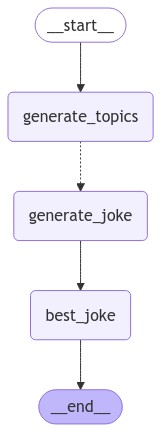

In [18]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [19]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "動物"}):
    print(s)

{'generate_topics': {'subjects': ['動物の生態', '動物の行動', '動物の保護']}}
{'generate_joke': {'jokes': ['なぜカメはいつも遅刻するの？\n\nだって、彼らは「甲羅（コーラ）を飲む」時間が必要だから！']}}
{'generate_joke': {'jokes': ['動物園で働く友達に「動物の保護活動って大変？」と聞いたら、「そうだね、特にカメの保護は時間がかかるよ。だって、彼らはいつも遅刻するんだ！」と言ってたよ。']}}
{'generate_joke': {'jokes': ['なぜ猫はコンピュータの上に座るのが好きなの？\n\n答え：それは、マウスを追いかけるためです！']}}
{'best_joke': {'best_selected_joke': 'なぜ猫はコンピュータの上に座るのが好きなの？\n\n答え：それは、マウスを追いかけるためです！'}}


## Studio

--

**⚠️ 注意**

*現在、Studioを実行するにはMacが必要です。Macを使用していない場合は、この手順をスキップしてください。*

*また、このノートブックをCoLabで実行している場合は、この手順をスキップしてください。*

--

上記のグラフをStudio UIに読み込みましょう。これは、`module-4/studio/langgraph.json`で設定された`module-4/studio/map_reduce.py`を使用します。

![Screenshot 2024-08-28 at 3.17.53 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb0c0ed88a12e822811e2_map-reduce1.png)